In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import colorsys
import pandas as pd
import glob

## Loading data

Yearly data downloaded as CSV from ENTSO-E: [France-2025](https://transparency.entsoe.eu/generation/actual/perType/generation?appState=%7B%22sa%22%3A%5B%22BZN%7C10YFR-RTE------C%22%5D%2C%22st%22%3A%22BZN%22%2C%22mm%22%3Atrue%2C%22ma%22%3Afalse%2C%22sp%22%3A%22HALF%22%2C%22dt%22%3A%22TABLE%22%2C%22df%22%3A%5B%222025-01-01%22%2C%222025-01-07%22%5D%2C%22tz%22%3A%22CET%22%7D)

In [346]:
filename = glob.glob("data-entsoe/*2024*2025*FR.csv")[0]
df = pd.read_csv(filename, sep=",")

In [347]:
df.head()

MTU (CET/CEST)    Area Production Type  \
0  01/01/2025 00:00:00 - 01/01/2025 00:15:00  BZN|FR         Biomass   
1  01/01/2025 00:15:00 - 01/01/2025 00:30:00  BZN|FR         Biomass   
2  01/01/2025 00:30:00 - 01/01/2025 00:45:00  BZN|FR         Biomass   
3  01/01/2025 00:45:00 - 01/01/2025 01:00:00  BZN|FR         Biomass   
4  01/01/2025 01:00:00 - 01/01/2025 01:15:00  BZN|FR         Biomass   

  Generation (MW)  
0          342.31  
1          341.56  
2          362.69  
3          361.64  
4          361.11

In [348]:
# Time cleaning
df["MTU (CET/CEST)"] = pd.to_datetime(df["MTU (CET/CEST)"].str[:19], format="%d/%m/%Y %H:%M:%S")
dt_hours = df["MTU (CET/CEST)"].diff()[1].seconds/3600

In [349]:
# Remove n/e values
df.loc[df["Generation (MW)"] == "n/e", "Generation (MW)"] = 0
df.loc[df["Generation (MW)"] == " ", "Generation (MW)"] = 0
df["Generation (MW)"] = df["Generation (MW)"].astype(float)
df.loc[df["Generation (MW)"].isna(), "Generation (MW)"] = 0

# Remove absent production types
absent = df.groupby("Production Type")["Generation (MW)"].sum()==0
df = df[~df["Production Type"].isin(absent[absent].index)]

## Plots

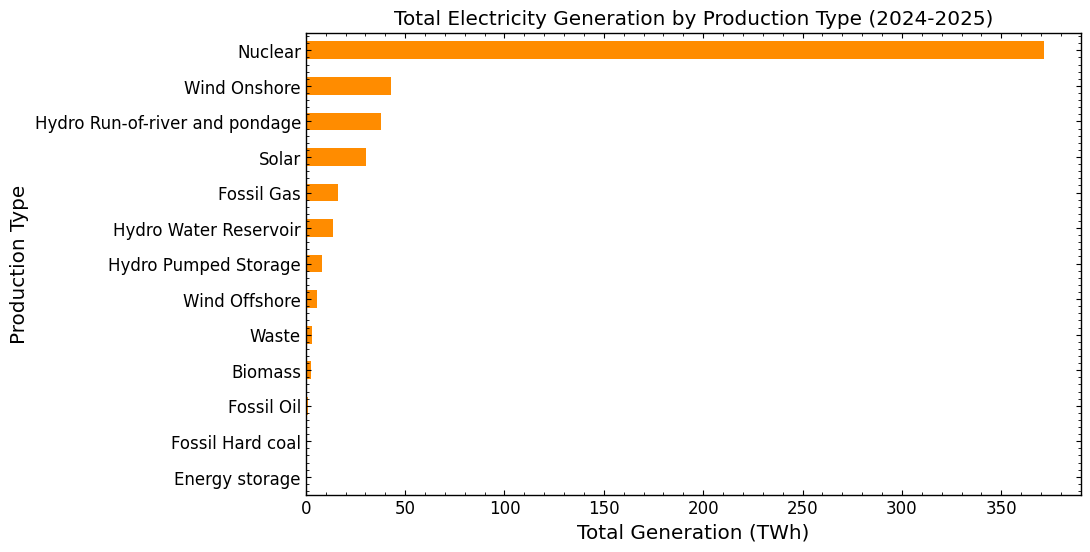

In [350]:
fig, ax = plt.subplots(figsize=(10, 6))
energy_prod = df.groupby("Production Type")["Generation (MW)"].sum()*dt_hours / 1e6 # in TWh
energy_prod.sort_values().plot(ax=ax, kind="barh", color="darkorange")
ax.set_xlabel("Total Generation (TWh)")
ax.set_title("Total Electricity Generation by Production Type (2024-2025)")
plt.show()

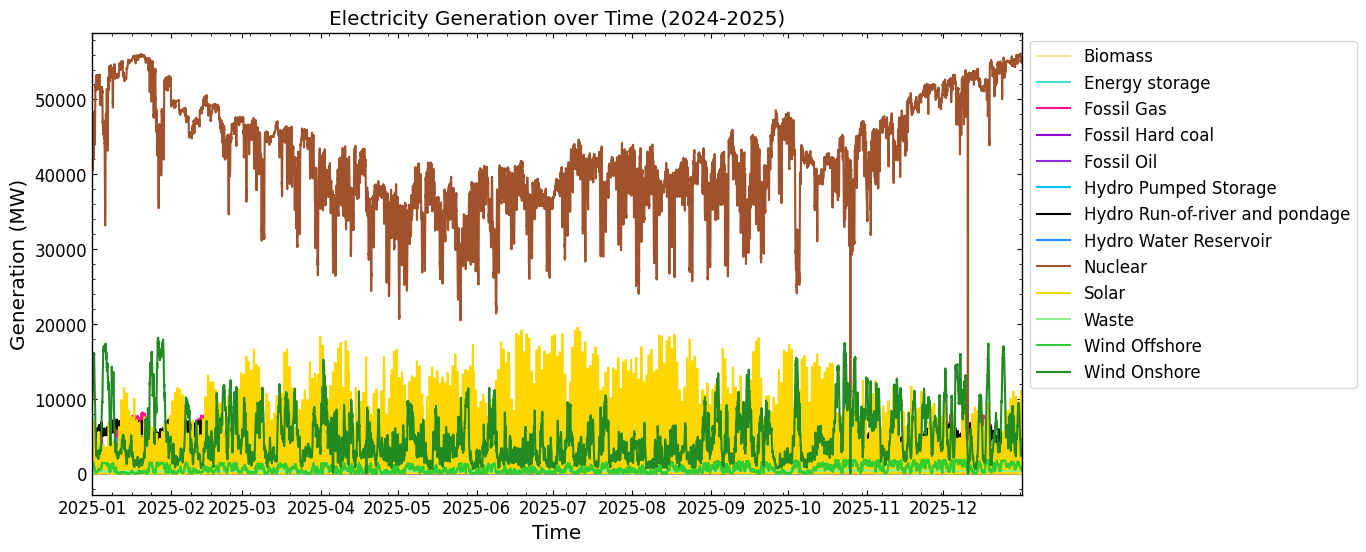

In [351]:
prod_types = df["Production Type"].unique()
colors = {'Biomass': 'khaki',
          'Energy storage': 'turquoise',
          'Fossil Gas': 'deeppink',
          'Fossil Hard coal': 'darkviolet',
          'Fossil Oil': 'blueviolet',
          'Hydro Pumped Storage': 'deepskyblue',
          'Hydro Run-of-river and poundage': 'lightblue',
          'Hydro Water Reservoir': 'dodgerblue',
          'Nuclear': 'sienna',
          'Solar': 'gold',
          'Waste': 'lightgreen',
          'Wind Offshore': 'limegreen',
          'Wind Onshore': 'forestgreen'}

fig, ax = plt.subplots(figsize=(12, 6))
for ptype in prod_types:
# for ptype in ["Hydro Run-of-river and pondage", "Hydro Pumped Storage", "Hydro Water Reservoir",]:
    df_ptype = df[df["Production Type"] == ptype]
    ax.plot(df_ptype["MTU (CET/CEST)"], df_ptype["Generation (MW)"], label=ptype, color=colors.get(ptype, 'black'))
ax.set_xlabel("Time")
ax.set_ylabel("Generation (MW)")
ax.set_title(f"Electricity Generation over Time (2024-2025)")
ax.set_xlim(df["MTU (CET/CEST)"].min(), df["MTU (CET/CEST)"].max())
# ax.set_xlim(pd.Timestamp("2025-01-01"), pd.Timestamp("2025-01-31"))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [352]:
total_prod = df.groupby("MTU (CET/CEST)")["Generation (MW)"].sum().reset_index()

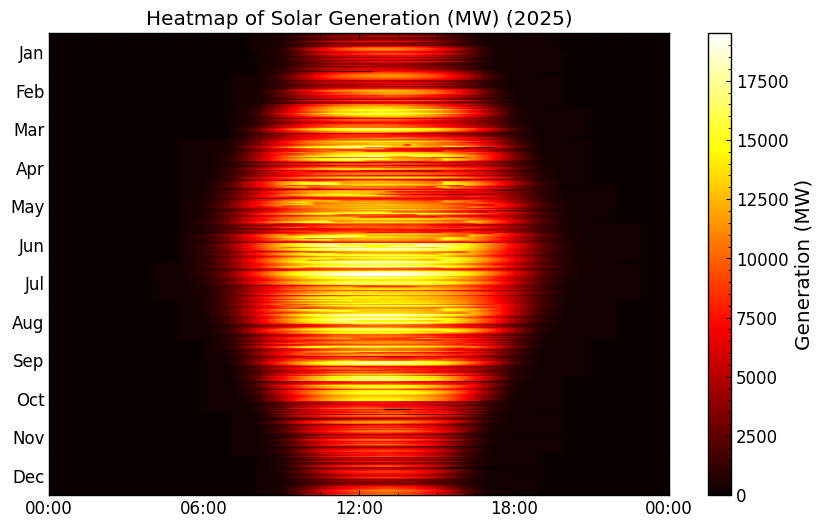

In [353]:
ptype = "Solar"
df_ptype = df[df["Production Type"] == ptype].reset_index()
prod_matrix = df_ptype["Generation (MW)"].values.reshape(-1, int(24/dt_hours))  # Reshape to days x hours
prod_matrix[np.isnan(prod_matrix)] = 0

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(prod_matrix, aspect='auto', cmap='hot', extent=[0, 24, prod_matrix.shape[0], 0], vmin=0, vmax=prod_matrix.max())
ax.set_xticks(np.arange(0, 25, 6), labels=["00:00", "06:00", "12:00", "18:00", "00:00"])
ax.set_yticks(np.arange(15, prod_matrix.shape[0]+1, 365/12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.set_title(f"Heatmap of {ptype} Generation (MW) ({df_ptype["MTU (CET/CEST)"][0].year})")
plt.colorbar(ax.images[0], ax=ax, label="Generation (MW)")
plt.show()

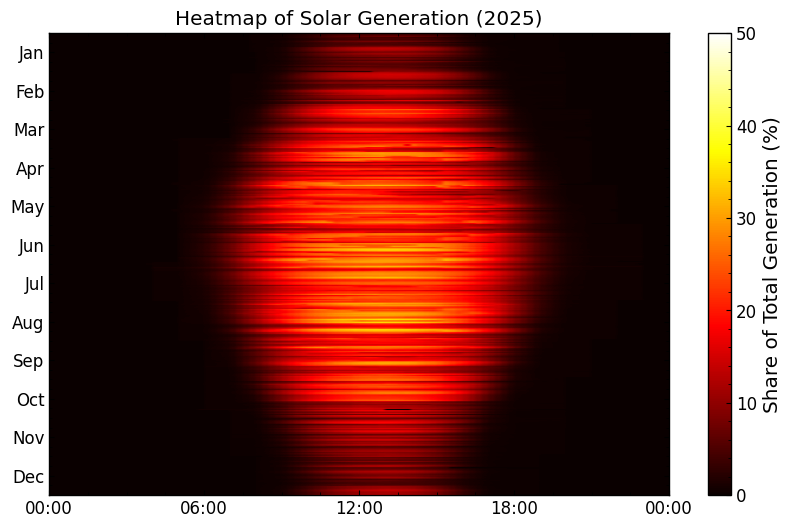

In [354]:
df_merged = pd.merge(df_ptype, total_prod, on="MTU (CET/CEST)", suffixes=('_ptype', '_total'))
df_merged["Share (%)"] = (df_merged["Generation (MW)_ptype"] / df_merged["Generation (MW)_total"]) * 100
prod_matrix_share = df_merged["Share (%)"].values.reshape(-1, int(24/dt_hours))
prod_matrix_share[np.isnan(prod_matrix_share)] = 0

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(prod_matrix_share, aspect='auto', cmap='hot', extent=[0, 24, prod_matrix_share.shape[0], 0], vmin=0, vmax=50)
ax.set_xticks(np.arange(0, 25, 6), labels=["00:00", "06:00", "12:00", "18:00", "00:00"])
ax.set_yticks(np.arange(15, prod_matrix_share.shape[0]+1, 365/12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.set_title(f"Heatmap of {ptype} Generation ({df_ptype["MTU (CET/CEST)"][0].year})")
plt.colorbar(ax.images[0], ax=ax, label="Share of Total Generation (%)")
# fig.savefig(f"heatmap_{ptype.lower()}.png", bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.show()

In [355]:
def hue_hot(rot_deg):
    x = np.linspace(0, 1, 256)
    rgb = mpl.colormaps['hot'](x)
    hsv = [colorsys.rgb_to_hsv(r,g,b) for (r,g,b,a) in rgb]
    new_rgb = [colorsys.hsv_to_rgb((h + (np.deg2rad(rot_deg)/(2*np.pi)))%1,s,v) for (h, s, v) in hsv]
    new_cmap = ListedColormap(new_rgb)
    return new_cmap

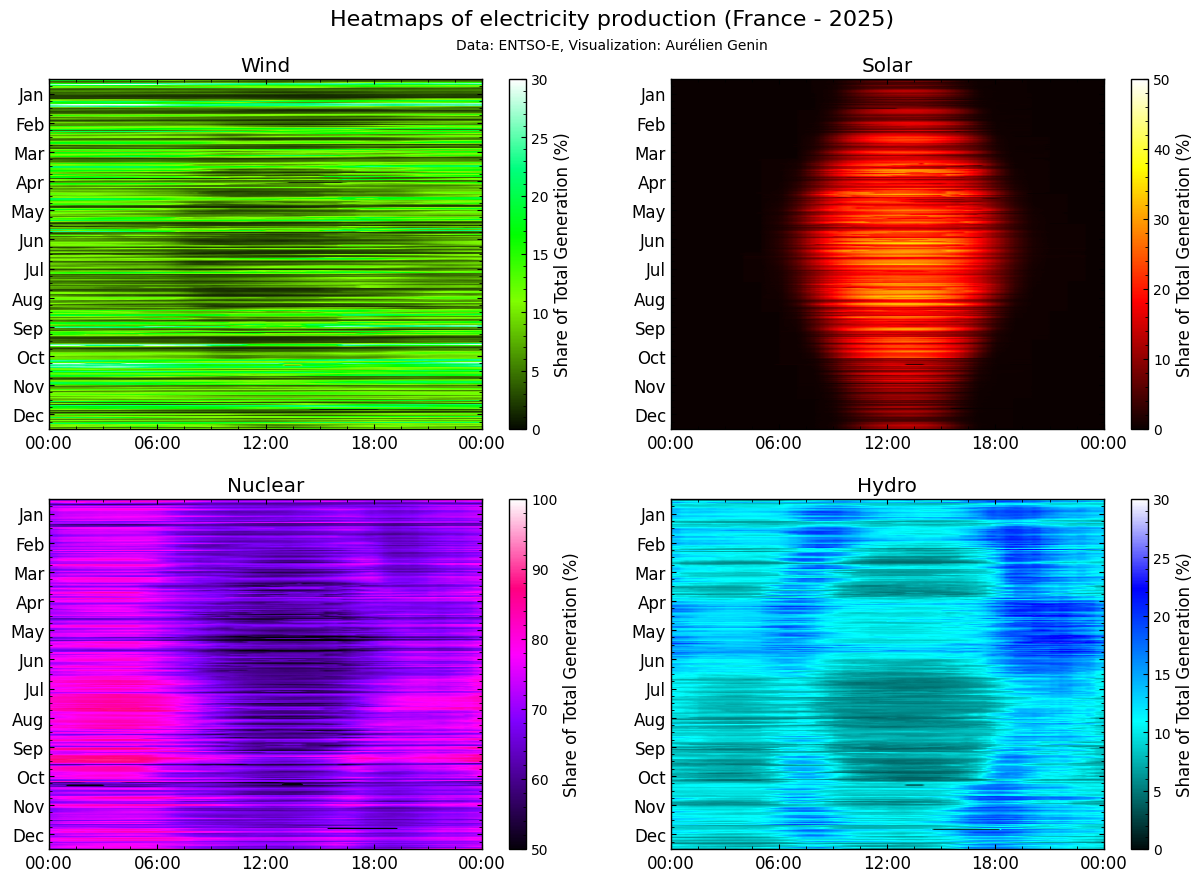

In [356]:
ptypes = [("Wind Onshore", "Wind Offshore"), "Solar", "Nuclear", ("Hydro Run-of-river and pondage", "Hydro Pumped Storage", "Hydro Water Reservoir")]
ranges = [(0, 30), (0, 50), (50, 100), (0, 30)]
cmap = [hue_hot(90), hue_hot(0), hue_hot(-90), hue_hot(180)]

fig, axs = plt.subplots(2,2, figsize=(15, 10), gridspec_kw={'hspace': 0.2, 'wspace': 0.15})

for i, ptype in enumerate(ptypes):
    ax = axs[i//2, i%2]
    if isinstance(ptype, tuple):
        df_ptype = df[df["Production Type"].isin(ptype)].reset_index()
        df_ptype = df_ptype.groupby("MTU (CET/CEST)")["Generation (MW)"].sum().reset_index()
    else:
        df_ptype = df[df["Production Type"] == ptype].reset_index()
    df_merged = pd.merge(df_ptype, total_prod, on="MTU (CET/CEST)", suffixes=('_ptype', '_total'))
    df_merged["Share (%)"] = (df_merged["Generation (MW)_ptype"] / df_merged["Generation (MW)_total"]) * 100
    if len(df_merged) % int(24/dt_hours) != 0:
        # Trim excess rows to make reshaping possible
        df_merged = df_merged.iloc[:-(len(df_merged) % int(24/dt_hours))]
    prod_matrix_share = df_merged["Share (%)"].values.reshape(-1, int(24/dt_hours))
    prod_matrix_share[np.isnan(prod_matrix_share)] = 0

    ax.imshow(prod_matrix_share, aspect='auto', cmap=cmap[i], extent=[0, 24, prod_matrix.shape[0], 0], vmin=ranges[i][0], vmax=ranges[i][1])
    ax.set_xticks(np.arange(0, 25, 6), labels=["00:00", "06:00", "12:00", "18:00", "00:00"])
    ax.set_yticks(np.arange(15, prod_matrix.shape[0]+1, 365/12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    if isinstance(ptype, tuple):
        ax.set_title(ptype[0].split(" ")[0])
    else:
        ax.set_title(ptype)
    clb = plt.colorbar(ax.images[0], ax=ax)
    clb.set_label("Share of Total Generation (%)", fontsize='large')
    clb.ax.tick_params(labelsize='medium')

fig.suptitle(f"Heatmaps of electricity production (France - {df_ptype['MTU (CET/CEST)'][0].year})", fontsize=16, y=0.95)
fig.text(0.5, 0.91, "Data: ENTSO-E, Visualization: Aurélien Genin", fontsize=10, horizontalalignment="center")
# fig.savefig(f"heatmap_multiple_ptypes.png", bbox_inches='tight', dpi=300, pad_inches=0.1)
plt.show()
    